# Sentiment Analysis of #TTC Tweets - Part 2 of 3

Welcome to Part 2 of our three-part project in which we analyze the sentiment of tweets featuring the #TTC hashtag. In [Part 1](https://github.com/ssorkhou/ttc_tweets/blob/main/Part_1_-_Sentiment_Analysis_of_%23TTC_Tweets.ipynb) we studied the tweets in our dataset, perforiming sentiment analysis and discovering interesting trends in the tweets. In this section of the project we will have a look at the subway closure data, which consists of information regarding the many subway closures between January 1, 2014 and June 30, 2021, inclusive (this is the same range of dates as our Twitter dataset). Note that this dataset only has information on the *scheduled* subway closures. Unplanned service disruptions are found in the subway delay dataset which we will examine in [Part 3](https://github.com/ssorkhou/ttc_tweets/blob/main/Part_3_-_Sentiment_Analysis_of_%23TTC_Tweets.ipynb).

The TTC works every night to maintain and upgrade Toronto's subway system but not too much can get done each night. Currently, subway service starts at 6 am and ends between 1 and 2 am, leaving a handful of hours during which work can be done. After accounting for the time needed to set up the necessary equipment, "[typically less than two hours of work can be acheived each night](https://www.ttc.ca/About_the_TTC/Commission_reports_and_information/Commission_meetings/2019/April_11/Reports/20_Subway_Closures_2018_Review_and_2019_Forecast.pdf)". This is not a whole lot of time for many of the TTC's projects and so the TTC must frequently close portions of the subway system in order to work for longer periods. While frustrating, subway closures are necessary and the TTC often touts that a single weekend closure is equivalent to five weeks of overnight work.

We will do some exploratory analysis of this subway closure dataset. We will also try to link this dataset with our tweets from Part 1. Ultimately we hope to find relationships between the two sets of data.

## Importing Libraries

As before we import the required libraries.

In [1]:
# import libraries
import numpy as np # for arrays
import pandas as pd # for dataframes
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for data visualization
import datetime # for handling dates
from datetime import datetime as dt # also for dates
import calendar # also for dates
import string # for strings
import re # for regular expressions
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer # for sentiment analysis
import nltk # for natural language processing
from nltk import tokenize # for tokenizing text
from scipy import stats # for statistics test
from statsmodels.stats.multitest import multipletests # for applying Holm-Bonferroni corrections
from wordcloud import WordCloud # for word clouds
import folium # for mapping
from folium.plugins import HeatMap # for heatmaps

# set preferences
sns.set_style('whitegrid')
%matplotlib inline
pd.set_option('display.max_colwidth', 400)

# for the punkt sentence tokenizer
nltk.download('punkt')

## Loading the Data

The subway closure data was manually extracted from the [TTC News page](https://ttc.ca/News/index.jsp). The dataset consists of all subway closures within the same time frame as the Twitter data, e.g. between January 1, 2014 and June 30, 2021, inclusive. Let's load it in.

In [2]:
# load closure data
closures = pd.read_csv('closures/closures.csv')

We will also require the Twitter dataset from Part 1.

In [3]:
# load Twitter data
tweets = pd.read_csv('tweets/tweets_post_part_1.csv', index_col = 0)
tweets_per_day = pd.read_csv('tweets/tweets_per_day_post_part_1.csv', index_col = 0)

## Cleaning the Closure Data

Let's have a look at what sort of information is recorded in the subway closures dataset.

In [4]:
# preview closure data
closures.head()

,date,line,type
0,11-Jan-14,1,Weekend
1,12-Jan-14,1,Weekend
2,25-Jan-14,1,Weekend
3,26-Jan-14,1,Weekend
4,08-Feb-14,1,Weekend


In [5]:
# closure dataset features
closures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 793 entries, 0 to 792
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    793 non-null    object
 1   line    793 non-null    int64 
 2   type    793 non-null    object
dtypes: int64(1), object(2)
memory usage: 18.7+ KB


There are 793 subway closures in the dataset. For each closure, three features are recorded:

* **date** - the date of the subway closure
* **line** - the subway line affected by the closure
* **type** - the type of subway closure

There is not much cleaning that we have to do. There are no null values and both **line** and **type** are already of the appropriate data types, namely integers and strings, respectively. The only thing we should definitely do is convert the **date** values to datetime objects.

In [6]:
# convert to datetime object
closures['date'] = pd.to_datetime(closures['date'], format = '%d-%b-%y')
closures['date'] = closures['date'].apply(lambda x: x.date())

It wouldn't hurt to also create year, month, and day of the week features as well.

In [7]:
# create year, month, and day of the week features
closures['year'] = closures['date'].apply(lambda x: x.year)
closures['month'] = closures['date'].apply(lambda x: x.month)
closures['dayOfWeek'] = closures['date'].apply(lambda x: calendar.day_name[x.weekday()])

## Cleaning the Twitter data

The Twitter data was already cleaned in Part 1 of this project. However, in saving the dataframes as csv files the values of the **date** feature were converted from datetime objects to strings. Let's convert them back.

In [8]:
# Twitter dataframes
twitter_dfs = [tweets, tweets_per_day]

# loop through dataframes
for df in twitter_dfs:

    # convert to datetime
    df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')

    # extract the day
    df['date'] = df['date'].apply(lambda x: x.date())

## Exploring the Closure Data

There are only three features in the subway closure dataset but we can still extrapolate plenty of useful information from it.

### Closures Over Time

Perhaps the most natural place to start is to examine the subway closures over time.

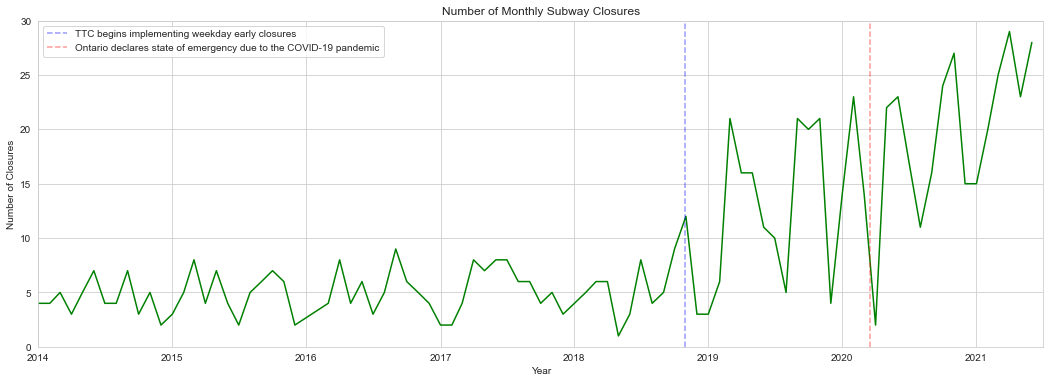

In [9]:
# counts per month
closures_per_month = closures.groupby(['year', 'month']).count()['date'].reset_index()

# rename column
closures_per_month.columns = ['year', 'month', 'numClosures']

# index for plotting
closures_per_month['firstOfMonth'] = closures_per_month.apply(lambda x: dt(x['year'], x['month'], 1).date(), axis = 1)

# important dates
early = dt(2018, 10, 29).date()
covid = dt(2020, 3, 17).date()

# make plot
alpha = 0.4
plt.figure(figsize = (18, 6))
fig = sns.lineplot(data = closures_per_month, x = 'firstOfMonth', y = 'numClosures', color = 'g')
plt.axvline(early, color = 'b', label = 'TTC begins implementing weekday early closures', ls = '--', alpha = alpha)
plt.axvline(covid, color = 'r', label = 'Ontario declares state of emergency due to the COVID-19 pandemic', ls = '--',
            alpha = alpha)
fig.set(title = 'Number of Monthly Subway Closures', xlabel = 'Year', ylabel = 'Number of Closures',
        xlim = [dt(2014, 1, 1), dt(2021, 7, 1)], ylim = [0, 30])
plt.legend()
plt.show()

There are a few observations we can make based off the plot above. Firstly, since the beginning of our dataset every month has had at least one subway closure.

Secondly, despite there being on average 9 closures per month we find that for the first three and a half years the number of monthly closures *never* exceeds this mean. As such it makes sense to split our time frame into phases. The first phase consists of the period before November of 2018. During this time the number of monthly subway closures consistently fluctuated around a mean and median of roughly 5 closures per month. The second phase comprises the period of November 2018 to March 17, 2021, which is the day the government of Ontario issued a [state of emergency](https://globalnews.ca/news/6688074/ontario-doug-ford-coronavirus-covid-19-march-17/) because of COVID-19. During this second period the number of monthly subway closures drastically increases with a mean and median of about 13 and 14 subway closures per month, respectively. The third phase is everyday from March 17, 2021 onwards. During this time the average number of monthly subway closures increased further to a mean of apprxoimately 20 and a median of 22 closures per month.

Why might there be such a drastic change in the number of subway closures? Per this [TTC report](https://www.ttc.ca/About_the_TTC/Commission_reports_and_information/Commission_meetings/2019/April_11/Reports/20_Subway_Closures_2018_Review_and_2019_Forecast.pdf) the TTC began implementing weeknight early closures, specifically on Mondays to Thursdays, during the fall of 2018. Per TTC records the first implementation of this style of closure was on October 29, 2018. This explains why there are so many monthly closures from November of 2018 onwards.

The newly introduced weeknight early closures explains the first increase in closures but why is there a second increase during the COVID-19 pandemic? Well for one thing the TTC is [behind in its ATC upgrade project](https://www.ttc.ca/About_the_TTC/Commission_reports_and_information/Commission_meetings/2019/April_11/Reports/17_Automatic_Train_Control_Re-Baselining_and_Transit_Systems.pdf). Initially, this project was scheduled to be completed by late 2019 but at the time of this writing the expected completion date is September of 2022. To take advantage of reduced ridership during the COVID-19 pandemic, the TTC opted to schedule [additional closures](https://www.blogto.com/city/2020/12/ttc-closing-part-toronto-busiest-subway-line-10-days/) in hopes of completing the project before the predicted completion date.

While it is fairly evident from the graph we shall conduct a Kruskal-Wallis H-test to verify there is indeed a difference between the three phases.

In [10]:
# initialize dictionary of counts
phase = dict()

# get counts
phase[1] = closures_per_month[closures_per_month['firstOfMonth'] < early]['numClosures']
phase[2] = closures_per_month[(closures_per_month['firstOfMonth'] >= early)
                        & (closures_per_month['firstOfMonth'] < covid)]['numClosures']
phase[3] = closures_per_month[closures_per_month['firstOfMonth'] >= covid]['numClosures']

# perform Kruskal-Wallis H-test
pval = stats.kruskal(phase[1], phase[2], phase[3]).pvalue

# print p-value
print('Kruskal-Wallis H-test p-value: {:.2e}'.format(pval))

Kruskal-Wallis H-test p-value: 1.12e-08


With our significance level of 0.05 the Kruskal-Wallis H-test finds a statistically significant difference in the number of monthly closures between the three groups. We now employ Welch's t-tests with a Holm-Bonferroni correction to verify that all pairs of the three phases have statistically significant differences.

In [11]:
# initialize list of pairs and p-values
pairs = []
pvals = []

# loop through all pairs
for i in [1, 2, 3]:
    for j in [1, 2, 3]:
        if i < j:
            
            # compute p-value
            pval = stats.ttest_ind(phase[i], phase[j], equal_var = False).pvalue
            
            # append pair and p-value
            pairs.append((i, j))
            pvals.append(pval)
            
# initialize lists to store pairs with statistically significant differences
diff_pairs = []

# apply Holm-Bonferroni correction
hb = multipletests(pvals, method = 'holm')[0]

# loop through pairs
for i in range(len(pairs)):
    
    # check for pairs with statistically significant differences
    if hb[i]:
        
        # append to list of pairs
        diff_pairs.append(pairs[i])
        
# print pairs with statistically significant differences
print('Pairs with statistically significant differences:')
for pair in diff_pairs:
    print(pair)

Pairs with statistically significant differences:
(1, 2)
(1, 3)
(2, 3)


As expected, every pair of groupings has statistically significant differences. Therefore, we can indeed conclude that the average number of monthly subway closures increased once the TTC decided to implement weeknight early closures and then increased again during the pandemic.

Those who regularly use the TTC's subway system know that there are essentially four types of scheduled subway closures: weekend closures, single day closures, weeknight early closures, and late openings.

* Weekend closures are, as their name suggests, when the TTC closes a portion of a particular subway line for the entire weekend.
* Single day closures are similar except the closure lasts for just one day.
* Weeknight early closures are when the TTC ends subway service at 11 pm instead of the usual 1:30 am, providing them with a few additional hours of work. So while less work is accomplished during weeknight early closures, the negative impact of such closures on TTC customers is far less than the impact from weekend closures.
* Late openings are when the TTC begins subway service later than usual, thereby extending the amount of overnight work they can do. This option is rarely implemented due to its effect on those commuting to work.

Let's see the distribution of subway closures by type.

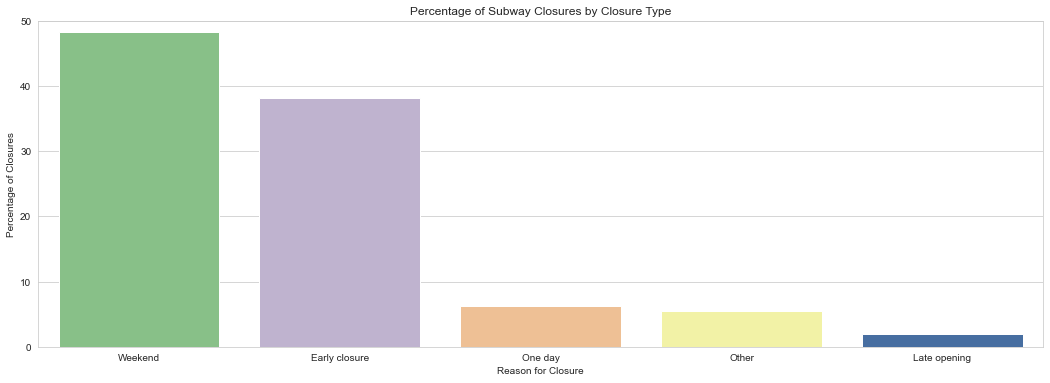

In [12]:
# compute percentages
perc = closures['type'].value_counts().reset_index()
perc['type'] *= 100 / closures.shape[0]

# rename columns
perc.columns = ['Reason for Closure', 'Percentage of Closures']

# make plot
plt.figure(figsize = (18, 6))
fig = sns.barplot(data = perc, x = 'Reason for Closure', y = 'Percentage of Closures', palette = 'Accent')
fig.set(title = 'Percentage of Subway Closures by Closure Type', ylim = [0, 50])
plt.show()

Weekend closures and weekday early closures make up the bulk of all subway closures. As such we expect that weekends have more closures than weekdays. We also expect that since weekday early closures are from Monday to Thursday that Fridays have relatively few closures. Let's see if our expectations are correct.

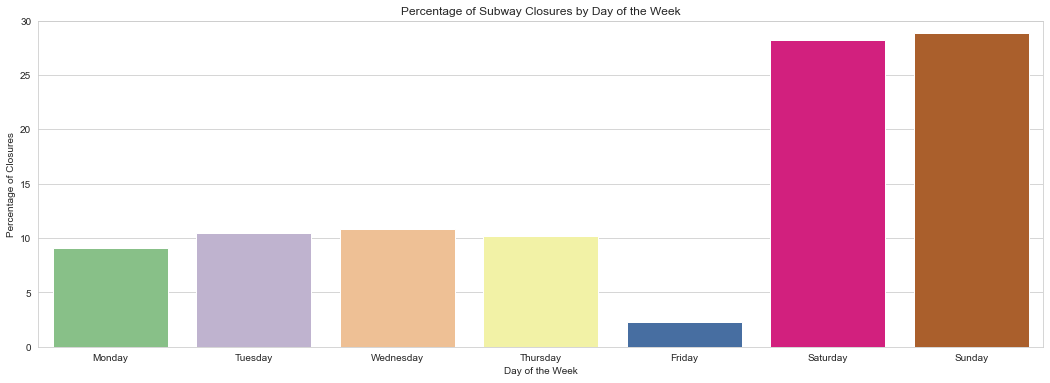

In [13]:
# list of days
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# compute percentages
perc = closures['dayOfWeek'].value_counts().reset_index()
perc['dayOfWeek'] *= 100 / closures.shape[0]

# rename columns
perc.columns = ['Day of the Week', 'Percentage of Closures']

# make plot
plt.figure(figsize = (18, 6))
fig = sns.barplot(data = perc, x = 'Day of the Week', y = 'Percentage of Closures', order = days, palette = 'Accent')
fig.set(title = 'Percentage of Subway Closures by Day of the Week', ylim = [0, 30])
plt.show()

Our suspicions appear correct. While we could verify using a chi-squared test, we choose not to since the difference is abundantly clear from the plot above.

### Subway Closures by Line

Now let's have a look at the subway closures by each subway line, starting with the percentage of closures by line.

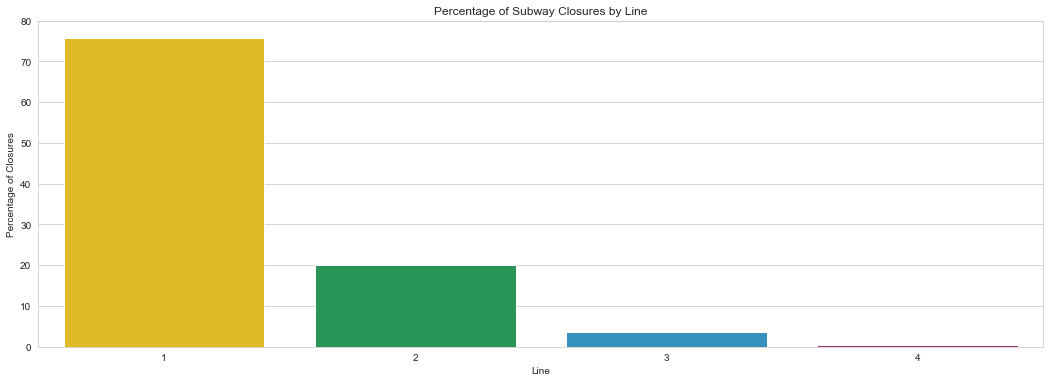

In [14]:
# compute percentages
perc = closures['line'].value_counts().reset_index()
perc['line'] *= 100 / closures.shape[0]

# rename columns
perc.columns = ['Line', 'Percentage of Closures']

# line colours
line_colours = {1:'#FFCB0C', 2:'#16A753', 3:'#1F99D5', 4:'#B32078'}

# make plot
plt.figure(figsize = (18, 6))
fig = sns.barplot(data = perc, x = 'Line', y = 'Percentage of Closures', palette = line_colours)
fig.set(title = 'Percentage of Subway Closures by Line', ylim = [0, 80])
plt.show()

Approximately three quarters of all subway closures affect Line 1, likely due to the [ATC signal upgrade project](https://www.ttc.ca/About_the_TTC/Projects/Automatic_Train_Control/index.jsp) for Line 1 as well as construction of the [Eglinton Crosstown](http://www.thecrosstown.ca/). About a fifth of closures affect Line 2, roughly 4% are on Line 3 and less than 1% of closures are on Line 4.

## Relationships With the Twitter Data

We turn our attention to the primary focus of Part 2 in which we attempt to link the closure data to our tweets from Part 1. The first question we will investigate is whether days with subway closures have more tweets than days without closures. We must however take into consideration the day of the week as well as whether the tweet takes place during the pandemic when making this comparison as otherwise we might fall for Simpson's paradox. Indeed, most subway closures occur on weekends but in Part 1 we found that weekends had the fewest number of tweets. Similarly, we found that the number of scheduled subway closures greatly increased during the pandemic but in Part 1 we noted that the number of daily tweets drastically fell during this time. Therefore, comparing the number of daily tweets on days with closures versus days without closures is not quite the right idea. What we do instead is make four comparisons, varying between whether it is a weekend or not and whether the tweet takes place during the pandemic or not.

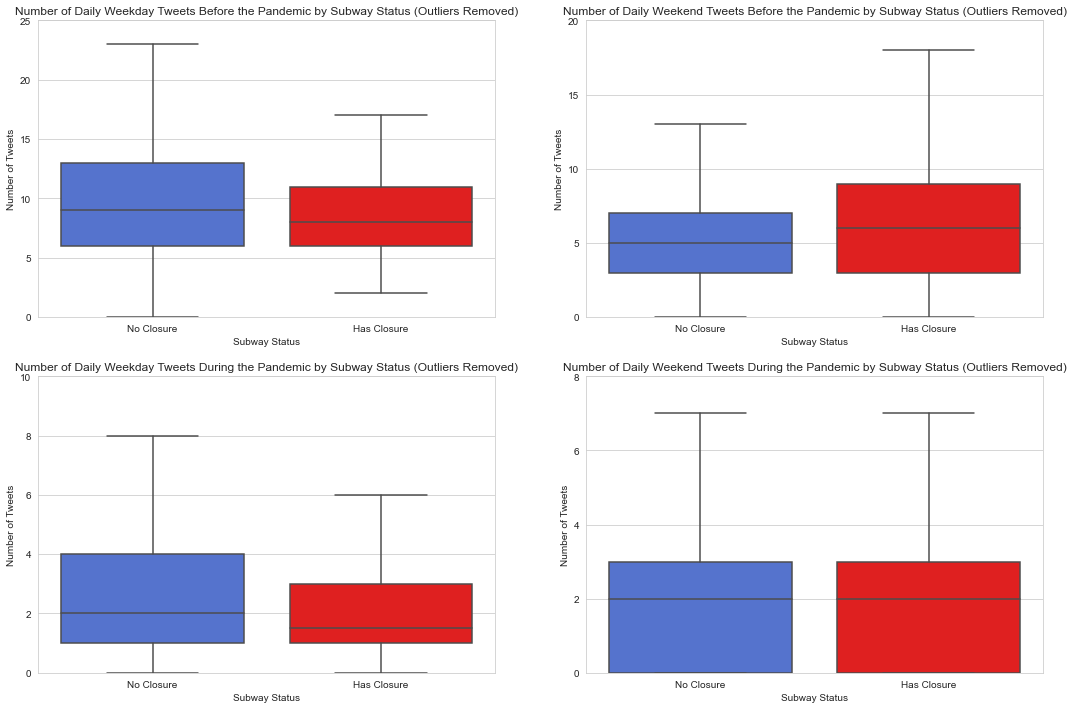

In [15]:
# feature to record whether there was a closure
tweets_per_day['closure'] = tweets_per_day['date'].apply(lambda x: 1 * (x in closures['date'].values))

# dictionary for plots
plots = {'dfs':{1:tweets_per_day[(~tweets_per_day['dayOfWeek'].isin(['Saturday', 'Sunday']))
                                 & (tweets_per_day['pandemic'] == 0)],
                2:tweets_per_day[(tweets_per_day['dayOfWeek'].isin(['Saturday', 'Sunday']))
                                 & (tweets_per_day['pandemic'] == 0)],
                3:tweets_per_day[(~tweets_per_day['dayOfWeek'].isin(['Saturday', 'Sunday']))
                                 & (tweets_per_day['pandemic'] == 1)],
                4:tweets_per_day[(tweets_per_day['dayOfWeek'].isin(['Saturday', 'Sunday']))
                                 & (tweets_per_day['pandemic'] == 1)]},
         'titles':{1:('Weekday', 'Before'), 2:('Weekend', 'Before'), 3:('Weekday', 'During'), 4:('Weekend', 'During')},
         'ylims':{1:[0, 25], 2:[0, 20], 3:[0, 10], 4:[0, 8]},
         'yticks':{1:np.arange(0, 30, 5), 2:np.arange(0, 25, 5), 3:np.arange(0, 12, 2), 4:np.arange(0, 10, 2)}
        }

# initialize figure
plt.figure(figsize = (18, 12))

# loop through plots
for i in range(1, 5):
        
    # make plot
    plt.subplot(2, 2, i)
    fig = sns.boxplot(data = plots['dfs'][i], x = 'closure', y = 'numTweets', showfliers = False,
                      palette = {0:'royalblue', 1:'r'})
    fig.set(title = 'Number of Daily {} Tweets {} the Pandemic by Subway Status (Outliers Removed)'.format(plots['titles'][i][0], plots['titles'][i][1]),
            xlabel = 'Subway Status', ylabel = 'Number of Tweets', ylim = plots['ylims'][i],
            xticklabels = ['No Closure', 'Has Closure'], yticks = plots['yticks'][i])
plt.show()

My original hypothesis was that within each group, there would on average be more tweets on days with subway closures than on days without. However, the box plots above seem to tell a different story. Indeed, independent of whether the tweet came from before the COVID-19 pandemic we find there are more tweets on weekdays *without* closures than on days with closures. Before we can draw any conclusions we should determine which differences are statistically siginificant via Welch's t-tests with a Holm-Bonferroni correction.

In [16]:
# initialize list of p-values
pvals = []

# loop through groups
for i in range(1, 5):
    
    # get relevant dataframe
    temp_df = plots['dfs'][i]
    
    # get counts
    a = temp_df[temp_df['closure'] == 0]['numTweets']
    b = temp_df[temp_df['closure'] == 1]['numTweets']
    
    # apply Welch's t-test
    pval = stats.ttest_ind(a, b, equal_var = False).pvalue
    
    # append to list
    pvals.append(pval)

# initialize list to store groups with statistically significant differences
diff_groups = []

# apply Holm-Bonferroni correction
hb = multipletests(pvals, method = 'holm')[0]

# loop through pairs
for i in range(4):
    
    # check for pairs with statistically significant differences
    if hb[i]:
        
        # append to list of groups
        diff_groups.append(i + 1)
        
# print groups with statistically significant differences
print('Groups with statistically significant differences:')
for group in diff_groups:
    print(group)

Groups with statistically significant differences:
1


The only group with a statistically significant difference in the number of daily tweets is the group of weekday tweets before the pandemic. In this group we actually have *more* tweets on pre-pandemic weekdays without closures than days with closures, with 10.8 tweets per day on days without closures versus 9.1 tweets per day on days with closures.

Just like in Part 1 this defies my original assumption of people resorting to Twitter to complain about the TTC. I thought people would voice their frustrations with subway closures, leading to an increase in tweets.

The number of tweets per day does not increase on days with closures but is there a difference in sentiment scores?

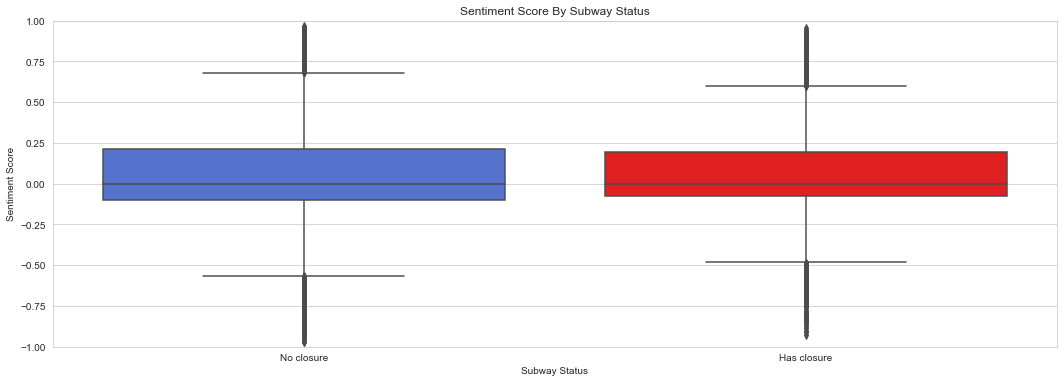

In [17]:
# feature to record whether there was a subway closure
tweets['closure'] = tweets['date'].apply(lambda x: 1 * (x in closures['date'].values))

# make plot
plt.figure(figsize = (18, 6))
fig = sns.boxplot(data = tweets, x = 'closure', y = 'score', palette = {0:'royalblue', 1:'r'})
fig.set(title = 'Sentiment Score By Subway Status', xlabel = 'Subway Status', ylabel = 'Sentiment Score', ylim = [-1, 1],
        xticklabels = ['No closure', 'Has closure'])
plt.show()

The distributions are nearly identical. I doubt that a Welch's t-test or a Mann-Whitney U-test will detect any statistically significant difference.

In [18]:
# tweet scores
a = tweets[tweets['closure'] == 0]['score']
b = tweets[tweets['closure'] == 1]['score']

# apply Welch's t-test
pval = stats.ttest_ind(a, b, equal_var = False).pvalue

# print p-value
print("Welch's t-test p-value: {:.2e}".format(pval))

Welch's t-test p-value: 7.12e-01


The result is far from significant and so we cannot conclude there is any difference in sentiment on days with subway closures versus days without them. While this result defies my initial expectations this is not terrible news. Indeed, we noted in Part 1 that many features had little effect on sentiment scores. Perhaps what we should instead consider is the proportions of positive and negative sentiments on days without closures and on days with closures.

In [19]:
# restrict attention to non-neutral tweets
has_sent = tweets[tweets['sentiment'] != 0]

# create frequency table
freq = has_sent.groupby(['sentiment', 'closure']).count()[['date']]
freq.columns = ['']
freq = freq.unstack()

# compute p-value and expected frequencies
chi = stats.chi2_contingency(freq)
pval = chi[1]
exp = pd.DataFrame(chi[3], index = [-1, 1])

# format expected frequencies table
exp.index.names = ['sentiment']
exp.columns.names = ['closure']

# print p-vale, frequency table, and expected frequency table
print('Chi-squared p-value: {:.2e}'.format(pval))
print('\n')
print('Frequency table:')
print(freq)
print('\n')
print('Expected frequency table:')
print(exp)

Chi-squared p-value: 6.18e-01


Frequency table:
                     
closure       0     1
sentiment            
-1         5218  1142
 1         6961  1558


Expected frequency table:
closure              0            1
sentiment                          
-1         5205.890181  1154.109819
 1         6973.109819  1545.890181


Unfortunately, whether or not there is a subway closure appears to have no effect on Twitter sentiment. So what do subway closures affect? After playing around with the data there does not seem to be too much affected by subway closures but there is one thing: media links. It turns out that on days with subway closures there are more media links than expected.

In [20]:
# feature recording whether a tweet has media
tweets['hasMedia'] = tweets['media'].apply(lambda x: 1 * (x > 0))

# create frequency table
freq = tweets.groupby(['hasMedia', 'closure']).count()[['date']]
freq.columns = ['']
freq = freq.unstack()

# compute p-value and expected frequencies
chi = stats.chi2_contingency(freq)
pval = chi[1]
exp = pd.DataFrame(chi[3])

# format expected frequencies table
exp.index.names = ['hasMedia']
exp.columns.names = ['closure']

# print p-value, frequency table, and expected frequency table
print('Chi-squared p-value: {:.2e}'.format(pval))
print('\n')
print('Frequency table:')
print(freq)
print('\n')
print('Expected frequency table:')
print(exp)

Chi-squared p-value: 5.30e-28


Frequency table:
                     
closure       0     1
hasMedia             
0         14241  3036
1          4104  1318


Expected frequency table:
closure              0            1
hasMedia                           
0         13963.018855  3313.981145
1          4381.981145  1040.018855


From the above we note that the amount of tweets with media links on days with closures is roughly 27% higher than expected and this difference is statistically significant. Why might this be? On days with subway closures, shuttle buses replace the usual subway service. Subway trains carry far more passengers than buses and so during peak commute hours the affected subway stations and shuttle buses can get rather crowded. Many tweets contain images to such situations such as the [tweet below](https://twitter.com/robynkndy/status/1227962765068918785).

In [21]:
# tweet with media link regarding subway closure
tweets[(tweets['username'] == 'robynkndy') & (tweets['date'] == dt(2020, 2, 13).date())][['date', 'content', 'username', 'media']]

,date,content,username,media
1411,2020-02-13,It's a special kind of hell day on the TTC #ttc #lineclosure #subway #namastayofftheaubway,robynkndy,1


Further investigation would need to be done to give credence to this hypothesis but it seems pretty reasonable. Let's leave this as a question to answer in a future iteration of this project.

## Conclusion

Our analysis of the subway closure data was short yet productive. We found that in our dataset there were essentially three stages of closures. The first stage had consistently few closures but this phase ended in the fall of 2019, during which time the TTC introduced weekday early closures. This second stage continued until the COVID-19 pandemic, whose onset began the third phase. During the pandemic, the TTC continued implementing weekday early closures but they also introduced additional closures to take advantage of reduced ridership. More than half of all days during the pandemic were affected by some sort of subway closure!

Since the TTC has reduced ridership on weekends the TTC tries to schedule a significant portion of closures on the weekend. This was illustrated in our dataset with nearly half of all closures scheduled as weekend closures. Due to workplace commutes the weekdays have much higher ridership and so full weekday closures are generally avoided. Instead, the TTC schedules early weeknight closures on Mondays to Thursdays and these types of closures were the second most popular. Because of this, we found that most closures were on Saturdays and Sundays with Mondays to Thursdays getting a moderate number of closures. Subway closures on Fridays were fairly rare with only approximately 2% of closures occurring on Fridays.

Torontonians who frequently travel along Line 1 were most affected by closures with three quarters of subway closures affecting Line 1. The frequent Line 1 closures can likely be attributed to the ATC signal upgrade project and construction of the Eglinton Crosstown.

To my surprise we were unable to discover many links between subway closures and Twitter sentiment. Indeed, Twitter sentiment appears completely unrelated to subway closures. I originally suspected there would be more tweets on days with closures but even that is untrue. The only relationship we could establish between subway closures and our tweets is that there were substantially more media links in tweets on days with closures than expected.

Scheduled subway closures seem to have little impact on tweets and Twitter sentiment. Is the situation different if we consider unexpected transit issues and delays? In Part 3 of this project we will study bus, streetcar, and subway delay data and attempt to find relationships with the Twitter data. Will we again find little relation with the tweets or are delays more impactful than subway closures when it comes to sentiment? Let's see in [Part 3](https://github.com/ssorkhou/ttc_tweets/blob/main/Part_3_-_Sentiment_Analysis_of_%23TTC_Tweets.ipynb)!